# Image Denoising Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a denoising model. For a given noisy image $X$, our model should learn to predict the denoised image $y$.


**Objectives**
- Visualize images
- Preprocess images for the neural network
- Fit a custom CNN for the task

Imports:

In [3]:
import glob

In [6]:
import PIL
import matplotlib.pyplot as plt

In [17]:
import numpy as np

In [39]:
from tqdm import tqdm

In [44]:
import tensorflow as tf

In [68]:
from sklearn.model_selection import train_test_split

In [77]:
from tensorflow.keras import layers, Sequential

In [94]:
from tensorflow.keras.callbacks import EarlyStopping

## 1. Load Data

👉 Let's download the dataset archive.
It contains RGB and Black & White images we will be using for the rest of this challenge.

In [1]:
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/paintings.zip > paintings.zip
! unzip -nq "paintings.zip" 
! rm "paintings.zip"
! ls -l

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 90.1M  100 90.1M    0     0  20.9M      0  0:00:04  0:00:04 --:--:-- 20.9M
total 48
-rw-r--r--     1 valentinlaurent  staff      0 Jun 29 09:20 README.md
-rw-r--r--@    1 valentinlaurent  staff  20937 Jun 30 09:05 image_denoising.ipynb
drwx------  1087 valentinlaurent  staff  34784 Jun  9 15:06 paintings
drwxr-xr-x     3 valentinlaurent  staff     96 Jun 29 09:20 tests


In [4]:
dataset_paths = glob.glob("./paintings/*.jpg")
dataset_paths

['./paintings/Joan_Miro_48.jpg',
 './paintings/Titian_232.jpg',
 './paintings/Amedeo_Modigliani_30.jpg',
 './paintings/Frida_Kahlo_21.jpg',
 './paintings/Marc_Chagall_59.jpg',
 './paintings/Salvador_Dali_116.jpg',
 './paintings/Vincent_van_Gogh_363.jpg',
 './paintings/Paul_Klee_47.jpg',
 './paintings/Kazimir_Malevich_106.jpg',
 './paintings/Leonardo_da_Vinci_7.jpg',
 './paintings/Francisco_Goya_199.jpg',
 './paintings/Vincent_van_Gogh_161.jpg',
 './paintings/Paul_Klee_90.jpg',
 './paintings/Paul_Cezanne_24.jpg',
 './paintings/Peter_Paul_Rubens_42.jpg',
 './paintings/Amedeo_Modigliani_184.jpg',
 './paintings/Titian_52.jpg',
 './paintings/Alfred_Sisley_165.jpg',
 './paintings/Paul_Gauguin_72.jpg',
 './paintings/Vincent_van_Gogh_767.jpg',
 './paintings/Raphael_106.jpg',
 './paintings/Pablo_Picasso_78.jpg',
 './paintings/Diego_Rivera_10.jpg',
 './paintings/Pieter_Bruegel_108.jpg',
 './paintings/Hieronymus_Bosch_25.jpg',
 './paintings/Joan_Miro_6.jpg',
 './paintings/Kazimir_Malevich_79.jpg'

❓ **Display the image at index `53` of this dataset_paths (i.e the 54-th image)**

<details>
    <summary>Hint</summary>
    Use the <code>PIL.Image.open</code> and <code>matplotlib.pyplot.imshow</code> functions.
</details>

In [9]:
image = PIL.Image.open(dataset_paths[53])

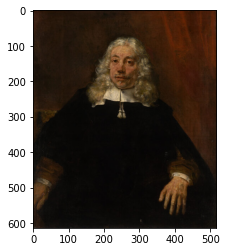

In [10]:
plt.imshow(image)

❓ **What is the shape of the image you displayed above `img_shape`?  How many dimensions `img_dim` does it have ?**

❓ **What was in the image above?**

In [24]:
# Not sure about the asked shape, for me it is the size, + the number of channels as last dimension
img_shape = image.size + (image.layers,)

# And the number of dimensions is then 3 : height, width, and color channels
img_dim = len(img_shape)

# Uncomment the correct answer

is_portrait = True
#is_portrait = False

is_colored_image = True
#is_colored_image = False

In [25]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    img_shape=img_shape,
    img_dim=img_dim,
    is_portrait=is_portrait,
    is_colored_image=is_colored_image
)

result.write()

## 2. Processing

❓ **Store all images from the dataset folder in a list of numpy arrays called `dataset_images`**

- It can take a while
- If the dataset is too big to fit in memory, just take the first half (or quarter) of all pictures

In [28]:
dataset_images = [np.asarray(PIL.Image.open(path)) for path in dataset_paths]

In [31]:
len(dataset_images)

1085

In [34]:
dataset_images[53].shape

(614, 517, 3)

### 2.1 Reshape, Resize, Rescale

Let's simplify our dataset and convert it to a single numpy array

❓ **First, check if that all the images in the dataset have the same number of dimensions**.
- What do you notice?
- How do you explain it? 

In [ ]:
np.unique(np.array([image.ndim for image in dataset_images]))

We can see that some images have 2 dimensions, some 3.

This is probably because we have both black and white and colored images

👉 We convert for you all black & white images into 3-colored ones by duplicating the image on three channels, so as to have only 3D arrays

In [40]:
dataset_images = [x if x.ndim==3 else np.repeat(x[:,:,None], 3, axis=2) for x in tqdm(dataset_images)]
set([x.ndim for x in dataset_images])

100%|██████████| 1085/1085 [00:01<00:00, 940.23it/s]


{3}

❓ **What about their shape now ?**
- Do they all have the same width/heights ? If not:
- Resize the images (120 pixels height and 100 pixels width) in the dataset, using `tensorflow.image.resize` function.
- Now that they all have the same shape, store them as a numpy array `dataset_resized`.
- This array should thus be of size $(n_{images}, 120, 100, 3)$

In [43]:
# Let's try the "set" method you used in the cell above
set([image.shape for image in dataset_images])

{(140, 180, 3),
 (150, 146, 3),
 (180, 124, 3),
 (180, 125, 3),
 (192, 319, 3),
 (211, 614, 3),
 (215, 187, 3),
 (228, 146, 3),
 (228, 186, 3),
 (229, 300, 3),
 (233, 480, 3),
 (234, 312, 3),
 (235, 189, 3),
 (236, 329, 3),
 (240, 180, 3),
 (240, 191, 3),
 (241, 228, 3),
 (245, 318, 3),
 (246, 614, 3),
 (249, 362, 3),
 (253, 173, 3),
 (260, 600, 3),
 (263, 614, 3),
 (270, 181, 3),
 (270, 193, 3),
 (270, 225, 3),
 (277, 362, 3),
 (277, 480, 3),
 (278, 450, 3),
 (281, 288, 3),
 (281, 362, 3),
 (283, 339, 3),
 (283, 614, 3),
 (283, 922, 3),
 (284, 362, 3),
 (284, 504, 3),
 (284, 600, 3),
 (286, 360, 3),
 (286, 614, 3),
 (288, 184, 3),
 (288, 203, 3),
 (288, 226, 3),
 (288, 252, 3),
 (288, 297, 3),
 (288, 350, 3),
 (288, 354, 3),
 (289, 480, 3),
 (293, 484, 3),
 (298, 600, 3),
 (298, 614, 3),
 (299, 218, 3),
 (299, 480, 3),
 (299, 600, 3),
 (299, 614, 3),
 (300, 231, 3),
 (300, 249, 3),
 (300, 251, 3),
 (300, 300, 3),
 (300, 812, 3),
 (300, 1436, 3),
 (302, 496, 3),
 (305, 450, 3),
 (305, 

Indeed we have a lot of different sizes. Let's resize:

In [51]:
dataset_resized = np.stack([tf.image.resize(image, [120,100]) for image in dataset_images])

In [52]:
dataset_resized.shape

(1085, 120, 100, 3)

❓ **Rescale the data of each image between $0$ and $1$**
- Save your resulting list as `dataset_scaled`

In [62]:
# Making sure min and max are 0 and 255:
print(np.amin(dataset_resized))
print(np.amax(dataset_resized))

0.0
255.0


In [64]:
# Scaling
dataset_scaled = dataset_resized / 255
dataset_scaled

array([[[[0.3556438 , 0.32948694, 0.36344773],
         [0.41529053, 0.37607485, 0.4074474 ],
         [0.37133497, 0.3268252 , 0.34760946],
         ...,
         [0.4434847 , 0.31407294, 0.34932458],
         [0.45864722, 0.33315703, 0.345     ],
         [0.4250095 , 0.2982251 , 0.31250015]],

        [[0.39482942, 0.36867258, 0.40263334],
         [0.37260392, 0.33338824, 0.3647608 ],
         [0.4063039 , 0.3617941 , 0.3825784 ],
         ...,
         [0.42392695, 0.2945152 , 0.3298093 ],
         [0.43445954, 0.30896935, 0.3285772 ],
         [0.40827528, 0.28149092, 0.3010207 ]],

        [[0.35246405, 0.3263072 , 0.36026797],
         [0.35856044, 0.31934476, 0.3507173 ],
         [0.40789217, 0.36338234, 0.38416666],
         ...,
         [0.4042806 , 0.27486885, 0.31279346],
         [0.39662766, 0.2672159 , 0.29474187],
         [0.3830315 , 0.2524889 , 0.28861848]],

        ...,

        [[0.26157683, 0.26416507, 0.30726314],
         [0.3922745 , 0.3569412 , 0.32937256]

### 2.2 Create (X,y) sets

👉 Now, we'll add for you some **random noise** to our images to simulate noise (that our model will try to remove later)

In [65]:
NOISE_LEVEL = 0.2

dataset_noisy = np.clip(
    dataset_scaled + np.random.normal(
        loc=0,
        scale=NOISE_LEVEL,
        size=dataset_scaled.shape
    ).astype(np.float32),
    0,
    1
)
dataset_noisy.shape

(1085, 120, 100, 3)

❓ **Plot a noisy image below to visualize the noise and compare it with the normal one**

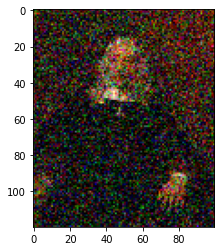

In [67]:
plt.imshow(dataset_noisy[53,:,:,:]);

❓ **Create your `(X_train, Y_train)`, `(X_test, Y_test)` training set for your problem**

- Remember you are trying to use "noisy" pictures in order to predict the "normal" ones.
- Keeping about `20%` of randomly sampled data as test set

In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset_noisy, dataset_scaled, test_size=0.2)

In [73]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(868, 120, 100, 3)
(217, 120, 100, 3)
(868, 120, 100, 3)
(217, 120, 100, 3)


In [74]:
from nbresult import ChallengeResult
result = ChallengeResult(
    "preprocessing",
    X_train_shape = X_train.shape,
    Y_train_shape = Y_train.shape,
    X_std = X_train[:,:,:,0].std(),
    Y_std = Y_train[:,:,:,0].std(),
    first_image = Y_train[0]
)
result.write()

## 3. Convolutional Neural Network

A commonly used neural network architecture for image denoising is the __AutoEncoder__.

<img src='https://github.com/lewagon/data-images/blob/master/DL/autoencoder.png?raw=true'>

Its goal is to learn a compact representation of your data to reconstruct them as precisely as possible.  
The loss for such model must incentivize it to have __an output as close to the input as possible__.

For this challenge, __you will only be asked to code the Encoder part of the network__, since building a Decoder leverages layers architectures you are not familiar with (yet).

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_painting_solution.pickle > data_painting_solution.pickle

import pickle
with open("data_painting_solution.pickle", "rb") as file:
    (X_train, Y_train, X_test, Y_test) = pickle.load(file)
    
! rm data_painting_solution.pickle
```

### 3.1 Architecture

👉 Run the cell below that defines the decoder

In [75]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Sequential

In [76]:
# We choose to compress images into a latent_dimension of size 6000
latent_dimensions = 6000

# We build a decoder that takes 1D-vectors of size 6000 to reconstruct images of shape (120,100,3)
decoder = Sequential(name='decoder')
decoder.add(layers.Reshape((30, 25, 8), input_dim=latent_dimensions))
decoder.add(layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2D(filters=3, kernel_size=3, padding="same", activation="sigmoid"))
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 30, 25, 8)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 60, 50, 16)        1168      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 120, 100, 32)      4640      
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 100, 3)       867       
Total params: 6,675
Trainable params: 6,675
Non-trainable params: 0
_________________________________________________________________


❓ **Now, build the `encoder` that plugs correctly with the decoder defined above**. Make sure that:
- The output of your `encoder` is the same shape as the input of the `decoder`
- Use a convolutional neural network architecture without transfer learning
- Keep it simple
- Print model summary

In [108]:
# CODE HERE YOUR ENCODER ARCHITECTURE AND PRINT IT'S MODEL SUMMARY

encoder = Sequential()
encoder.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(120, 100, 3), padding="same"))
encoder.add(layers.MaxPool2D(pool_size=(2,2)))
encoder.add(layers.Conv2D(8, kernel_size=(1, 1), activation='relu', padding="same"))
encoder.add(layers.MaxPool2D(pool_size=(2,2)))
encoder.add(layers.Flatten())

encoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 120, 100, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 60, 50, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 60, 50, 8)         264       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 30, 25, 8)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 6000)              0         
Total params: 1,160
Trainable params: 1,160
Non-trainable params: 0
_________________________________________________________________


👉 **Test your encoder below**

In [109]:
# HERE WE BUILD THE AUTO-ENCODER (ENCODER + DECODER) FOR YOU. IT SHOULD PRINT A NICE SUMMARY
from tensorflow.keras.models import Model

x = layers.Input(shape=(120, 100, 3))
autoencoder = Model(x, decoder(encoder(x)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 100, 3)]     0         
_________________________________________________________________
sequential_10 (Sequential)   (None, 6000)              1160      
_________________________________________________________________
decoder (Sequential)         (None, 120, 100, 3)       6675      
Total params: 7,835
Trainable params: 7,835
Non-trainable params: 0
_________________________________________________________________


### 3.2 Training

❓ **Before training the autoencoder, evaluate your baseline score**
- We will use the mean absolute error in this challenge
- Compute the baseline score on your test set in the "stupid" case where you don't manage to de-noise anything at all.
- Store the result under `score_baseline`

In [92]:
score_baseline = np.mean(abs(X_test-Y_test))
score_baseline

0.14250198

❓ Now, **train your autoencoder**

- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 5 minutes of training without GPUs.

In [110]:
autoencoder.compile(loss='mae',
                  optimizer='adam')

In [111]:
es = EarlyStopping(patience=5)
history = autoencoder.fit(X_train,y_train, epochs=30, validation_split=0.3, batch_size=16, verbose=1, callbacks=[es])

Epoch 1/100
38/38 [==============================] - 15s 384ms/step - loss: 0.2349 - val_loss: 0.2337
Epoch 2/100
38/38 [==============================] - 14s 361ms/step - loss: 0.2333 - val_loss: 0.2340
Epoch 3/100
38/38 [==============================] - 13s 335ms/step - loss: 0.2333 - val_loss: 0.2337
Epoch 4/100
38/38 [==============================] - 13s 342ms/step - loss: 0.2328 - val_loss: 0.2337
Epoch 5/100
38/38 [==============================] - 13s 339ms/step - loss: 0.2323 - val_loss: 0.2335
Epoch 6/100
38/38 [==============================] - 14s 380ms/step - loss: 0.2312 - val_loss: 0.2337
Epoch 7/100
38/38 [==============================] - 14s 362ms/step - loss: 0.2327 - val_loss: 0.2337
Epoch 8/100
38/38 [==============================] - 16s 412ms/step - loss: 0.2310 - val_loss: 0.2339
Epoch 9/100
38/38 [==============================] - 13s 332ms/step - loss: 0.2305 - val_loss: 0.2336
Epoch 10/100
38/38 [==============================] - 13s 349ms/step - loss: 0.228

❓ **Plot your training and validation loss at each epoch using the cell below**

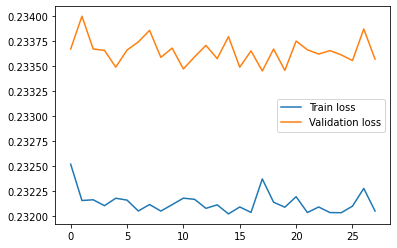

In [112]:
# Plot below your train/val loss history
plt.plot(history.history['loss'], label = "Train loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()

# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

I tried several models, all were underfitting. I tried adding some complexity but it didn't work.

Actually, all models were worst than the baseline 😬

I also tried to run a longer training, but it is not better. The image is the one of this last long training.

I'll come back to it later if I have time! Idea : **change learning rate**.

❓ **Evaluate your performances on test set**
- Compute your de-noised test set `Y_pred` 
- Store your test score as `score_test`
- Plot a de-noised image from your test set and compare it with the original and noisy one using the cell below

In [116]:
Y_pred = autoencoder.predict(X_test)
score_test = autoencoder.evaluate(X_test, Y_test)
score_test

7/7 [==============================] - 1s 142ms/step - loss: 0.2222


0.22216306626796722

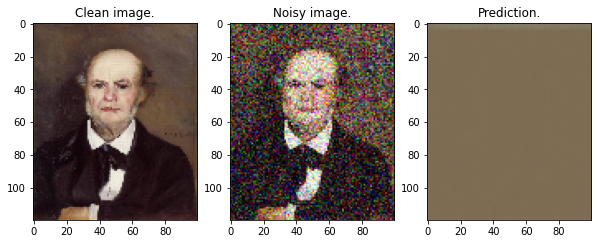

In [117]:
# RUN THIS CELL TO CHECK YOUR RESULTS
idx = 0

fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].imshow(Y_test[idx])
axs[0].set_title("Clean image.")

axs[1].imshow(X_test[idx])
axs[1].set_title("Noisy image.")

axs[2].imshow(Y_pred[idx])
axs[2].set_title("Prediction.")

# Run this to save your results for correction
plt.savefig('tests/image_denoised.png')

Seeing the prediction, maybe something's wrong in my model architecture.

🧪 **Send your results below**

In [118]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    input_shape = list(encoder.input.shape),
    output_shape = list(encoder.output.shape),
    layer_names = [layer.name for layer in encoder.layers],
    trainable_params = sum([tf.size(w_matrix).numpy() for w_matrix in encoder.trainable_variables]),
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()